Let's start by importing all the necessary modules 

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sqlalchemy import create_engine 

# display max columns 
pd.set_option('display.max_columns', None)

bring in the business data to extract the coffee shops from the list. 

Once we extract the coffee shops using the categories (search for 'Coffee and Tea'), then save off the df as an excel csv for initial EDA.

In [2]:
#business_df = pd.read_csv('business.csv') # read in business.csv as a dataframe
#coffee_shop_df = business_df[business_df['categories'].str.contains('Coffee & Tea', na=False)] # if cell is empty, treat it as false or it doesn't match 'Coffee & Tea'

#coffee_shop_df.to_csv("coffee_shop_list.csv",index=False)
coffee_shop_df = pd.read_csv('coffee_shop_list.csv')

# Top 10 Cities To Open A Coffee Shop in the US

Let's first take a look at the distribution of coffee shops on our list.

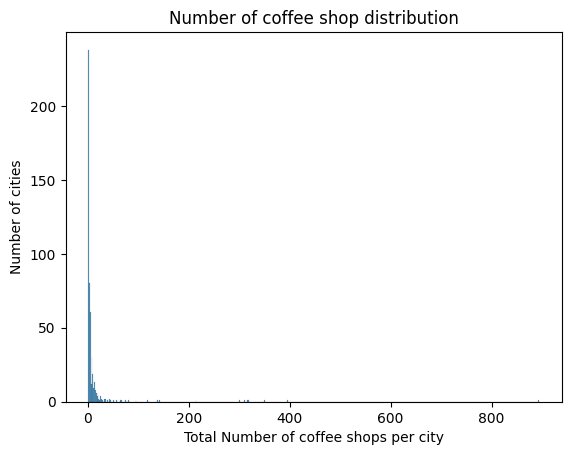

total number of cities is:  522
total number of cities with less than 10 coffee shops is:  421


In [3]:
# let's check what the spread of coffee shop data looks like for each city
coffee_shop_count_per_city_df = (
    coffee_shop_df
    .groupby('city')
    .size()
    .reset_index(name='num_coffee_shops')
)

sns.histplot(data=coffee_shop_count_per_city_df, x='num_coffee_shops')
plt.xlabel('Total Number of coffee shops per city')
plt.ylabel('Number of cities')
plt.title('Number of coffee shop distribution')
plt.show()

print("total number of cities is: ", len(coffee_shop_count_per_city_df))
print("total number of cities with less than 10 coffee shops is: ", len(coffee_shop_count_per_city_df[coffee_shop_count_per_city_df['num_coffee_shops'] < 10]))

So the number of coffee shops is really right skewed. We have a lot of outliers and 80% of the cities on our data have less than 10 coffee shops. Not the best distribution...

But we still want to include as many cities as possible in our list because there may be some cities that don't have a lot of coffee shops but are hidden potentials.

The other thing is that if a city has more coffee shop data, we would feel more confident in how the opportunity score of the coffee shop scene is in that city. So let's add a weighted metric to our opportunity score as well. For a city we fewer coffee shops, we'll decrease their final score by some amount.

First, let's start out with generating our condensed list of coffee shops that we want to evaluate. 

In [4]:
cities_10_coffee_shops = coffee_shop_count_per_city_df[coffee_shop_count_per_city_df['num_coffee_shops'] >= 10]
print("Total number of cities to evaluate: ", len(cities_10_coffee_shops))
print()

# filter out the coffee shop cities in our coffee_shop_df that have less than 10
condensed_coffee_shop_list_df = coffee_shop_df[coffee_shop_df['city'].isin(cities_10_coffee_shops['city'])]

#this is for postgreSQL star schema setup
condensed_coffee_shop_list_us_only_df = condensed_coffee_shop_list_df[~condensed_coffee_shop_list_df['state'].isin(['AB'])]
condensed_coffee_shop_list_us_only_df = condensed_coffee_shop_list_us_only_df[~condensed_coffee_shop_list_us_only_df['business_id'].str.contains("#NAME", na=False)]
condensed_coffee_shop_list_us_only_df.to_csv("condensed_coffee_shop_list_us_only.csv")

# add the total number of coffee shops per city to the condensed list
condensed_coffee_shop_list_df = condensed_coffee_shop_list_df.merge(coffee_shop_count_per_city_df, how='left',on='city')

print(condensed_coffee_shop_list_df.info())


Total number of cities to evaluate:  101

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5451 entries, 0 to 5450
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   business_id           5451 non-null   object 
 1   name                  5451 non-null   object 
 2   address               5432 non-null   object 
 3   city                  5451 non-null   object 
 4   state                 5451 non-null   object 
 5   postal_code           5450 non-null   object 
 6   latitude              5451 non-null   float64
 7   longitude             5451 non-null   float64
 8   city_land_area_sq_mi  5451 non-null   float64
 9   stars                 5451 non-null   float64
 10  review_count          5451 non-null   int64  
 11  is_open               5451 non-null   int64  
 12  attributes            5398 non-null   object 
 13  categories            5451 non-null   object 
 14  hours                 5030 non

~100 cities...still a sufficient list to choose from.

Alright, to determine the best cities to open a coffee shop in, we need to calculate a score for each city.

We will use this formula:
opportunity_score = median_check_ins * 0.4 + median_rating * 0.15 + median_review_counts * 0.15 + % of population in ages 25-39 * 0.1 – density * 0.2

We give more weight to median_check_ins because it is used to represent foot traffic. We want a lot of customers to come into our new shop. 
Median rating indicates how satisfied customers are with the shop. A high median rating suggests high-quality coffee shops, but this could be biased by a small number of reviews. 

So we include median review counts, which is used to represent how engaged customers are. High review counts suggest a strong coffee culture, but this can be inflated in very dense or tourist heavy cities.

NOTE: we are using median instead of average because there's no data availalbe for how long these coffee shops have been open for. An older coffee shop will have more reviews or check ins than one that just recently opened. Using the median value will make our calculations more robust to outliers.

I also include a % of population in ages 25-39 because people in that age group tend to go to coffee shops more. This is used to represent the potential of a city with a small or growing coffee shop scene. We are not giving much weight to it since it's a bit of a higher risk to open in a city that has high potential but not a strong coffee scene. 

We subtract coffee shop density from the opportunity score because a higher density will harm us more than help us. It's slightly more important than reviews and rating because when we start out as a new business, we don't want to start in a super dense area.

---

Let's start by getting the data for median_check_ins

In [5]:
coffee_shop_city_reviews_df = (
    condensed_coffee_shop_list_df
    .groupby('city')['review_count']
    .median()
    .round(2)
    .reset_index(name='median_review_counts')
)

print(coffee_shop_city_reviews_df.head(5))

         city  median_review_counts
0      Ambler                  10.5
1     Ardmore                  31.0
2  Belleville                  15.5
3    Bensalem                   9.0
4       Boise                  23.0


Lets get the data for median coffee shop ratings

In [6]:
# average star rating by city
coffee_shop_city_rating_df = (
    condensed_coffee_shop_list_df
    .groupby('city')['stars']
    .median() 
    .round(2)
    .reset_index(name='median_stars')
)

print(coffee_shop_city_rating_df.head(5))

         city  median_stars
0      Ambler          3.75
1     Ardmore          3.50
2  Belleville          4.50
3    Bensalem          3.50
4       Boise          4.00


Let's get a count of the total check-ins for each coffee shop.
We will be using check-ins as a proxy for foot traffic into the coffee shop

First, let's bring in the checkin data from checkin.csv

In [7]:
checkin_df = pd.read_csv('checkin.csv')

Now let's grab the total checkins from each business

In [8]:
# the check-in data is a list of checkins but in string format. we have to convert the string to a list and then determine the len of the list to 
# determine the total number of checkins. I wrote a function to do that and then applied it to each cell 
def checkin_counter(x):
    if pd.isna(x):
        return 0
    x_list = x.split(',')
    return len(x_list)

checkin_df['total_checkins'] = checkin_df['date'].apply(checkin_counter).astype(int)

Now lets merge the total checkin count for each coffee shop business. 

In [9]:
condensed_coffee_shop_list_df = condensed_coffee_shop_list_df.merge(checkin_df[['business_id','total_checkins']],how='left',on='business_id')

# if there are any shops with no checkins, fill in 0
condensed_coffee_shop_list_df['total_checkins'] = condensed_coffee_shop_list_df['total_checkins'].fillna(0)
print(condensed_coffee_shop_list_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5451 entries, 0 to 5450
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   business_id           5451 non-null   object 
 1   name                  5451 non-null   object 
 2   address               5432 non-null   object 
 3   city                  5451 non-null   object 
 4   state                 5451 non-null   object 
 5   postal_code           5450 non-null   object 
 6   latitude              5451 non-null   float64
 7   longitude             5451 non-null   float64
 8   city_land_area_sq_mi  5451 non-null   float64
 9   stars                 5451 non-null   float64
 10  review_count          5451 non-null   int64  
 11  is_open               5451 non-null   int64  
 12  attributes            5398 non-null   object 
 13  categories            5451 non-null   object 
 14  hours                 5030 non-null   object 
 15  num_coffee_shops     

Now lets calculate the median checkins for each city

In [12]:
coffee_shop_city_checkin_df = (
    condensed_coffee_shop_list_df
    .groupby('city')['total_checkins']
    .median()
    .round(2)
    .reset_index(name='median_checkin_count')
)

print(coffee_shop_city_checkin_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   city                  101 non-null    object 
 1   median_checkin_count  101 non-null    float64
dtypes: float64(1), object(1)
memory usage: 1.7+ KB
None


Now let's grab the coffee shop density for a city. We'll calculate how many coffee shops there are per 10k residents in each city.

In [ ]:
population_df = pd.read_csv('final_population_data_cleaned.csv')

# drop duplicates 
population_df_unique = population_df[['city','population_estimate','population_density','median_household_income']].drop_duplicates(subset='city')

# merge the population info into the condensed coffee shop list based on city
condensed_coffee_shop_list_df = condensed_coffee_shop_list_df.merge(population_df_unique, how='left',on='city')

print(condensed_coffee_shop_list_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5451 entries, 0 to 5450
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   business_id              5451 non-null   object 
 1   name                     5451 non-null   object 
 2   address                  5432 non-null   object 
 3   city                     5451 non-null   object 
 4   state                    5451 non-null   object 
 5   postal_code              5450 non-null   object 
 6   latitude                 5451 non-null   float64
 7   longitude                5451 non-null   float64
 8   city_land_area_sq_mi     5451 non-null   float64
 9   stars                    5451 non-null   float64
 10  review_count             5451 non-null   int64  
 11  is_open                  5451 non-null   int64  
 12  attributes               5398 non-null   object 
 13  categories               5451 non-null   object 
 14  hours                   

Now let's calculate the coffee shop density per 10k residents

In [17]:
condensed_coffee_shop_list_df['shops_per_10k_residents'] = condensed_coffee_shop_list_df['num_coffee_shops'] / (condensed_coffee_shop_list_df['population_estimate']/10000)
print(condensed_coffee_shop_list_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5451 entries, 0 to 5450
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   business_id                      5451 non-null   object 
 1   name                             5451 non-null   object 
 2   address                          5432 non-null   object 
 3   city                             5451 non-null   object 
 4   state                            5451 non-null   object 
 5   postal_code                      5450 non-null   object 
 6   latitude                         5451 non-null   float64
 7   longitude                        5451 non-null   float64
 8   city_land_area_sq_mi             5451 non-null   float64
 9   stars                            5451 non-null   float64
 10  review_count                     5451 non-null   int64  
 11  is_open                          5451 non-null   int64  
 12  attributes          

Let's take a look at the general stats of some of the features. 

In [18]:
print(condensed_coffee_shop_list_df.describe())

          latitude    longitude  city_land_area_sq_mi        stars  \
count  5451.000000  5451.000000           5451.000000  5451.000000   
mean     37.065330   -90.314088            136.413525     3.567602   
std       6.622994    15.331864            127.256470     0.986221   
min      27.713162  -119.972815              0.600000     1.000000   
25%      30.007994   -90.482720             32.900000     3.000000   
50%      39.505764   -86.149383            114.000000     4.000000   
75%      39.957034   -75.540612            169.500000     4.500000   
max      53.679197   -74.709329            475.780000     5.000000   

       review_count      is_open  num_coffee_shops  total_checkins  \
count   5451.000000  5451.000000       5451.000000     5451.000000   
mean      71.338653     0.717300        299.493487      209.120712   
std      160.405270     0.450353        294.149343      716.250961   
min        5.000000     0.000000         10.000000        0.000000   
25%       12.000000

Let's get the average coffee shop density per square mile for each city. While this is not part of our opportunity score formula, it would be nice to know. I'm not sure if I will use it in the future.

The coffee shop density per square miles tells us the how many packed the coffee shops are in each city while the density per 10k residents tells us how saturated the coffee shop scene is.

In [19]:
condensed_coffee_shop_list_df['coffee_shop_density_per_sq_mile'] = condensed_coffee_shop_list_df['num_coffee_shops'] / condensed_coffee_shop_list_df['city_land_area_sq_mi']
print(condensed_coffee_shop_list_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5451 entries, 0 to 5450
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   business_id                      5451 non-null   object 
 1   name                             5451 non-null   object 
 2   address                          5432 non-null   object 
 3   city                             5451 non-null   object 
 4   state                            5451 non-null   object 
 5   postal_code                      5450 non-null   object 
 6   latitude                         5451 non-null   float64
 7   longitude                        5451 non-null   float64
 8   city_land_area_sq_mi             5451 non-null   float64
 9   stars                            5451 non-null   float64
 10  review_count                     5451 non-null   int64  
 11  is_open                          5451 non-null   int64  
 12  attributes          

We finally need to grab the % of the population in ages 25-39. I'll have to get that from online. Once I do, add it to the condensed coffee shop list

In [20]:
city_age_pop_df = pd.read_csv('coffee_shop_cities_age_population.csv')

print(city_age_pop_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522 entries, 0 to 521
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   city          522 non-null    object 
 1   state         522 non-null    object 
 2   (Aged 25-39)  522 non-null    float64
dtypes: float64(1), object(2)
memory usage: 12.4+ KB
None


In [21]:
# since I grabbed the ages 25-39 percentage for each city in the original list, I have to condense down the list to the cities I want
condensed_city_age_pop_df = city_age_pop_df[city_age_pop_df['city'].isin(condensed_coffee_shop_list_df['city'])]

# now merge the age population to the condensed_coffee_shop_list
condensed_coffee_shop_list_df = condensed_coffee_shop_list_df.merge(condensed_city_age_pop_df[['city','(Aged 25-39)']], how='left', on='city')

print(condensed_coffee_shop_list_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5451 entries, 0 to 5450
Data columns (total 23 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   business_id                      5451 non-null   object 
 1   name                             5451 non-null   object 
 2   address                          5432 non-null   object 
 3   city                             5451 non-null   object 
 4   state                            5451 non-null   object 
 5   postal_code                      5450 non-null   object 
 6   latitude                         5451 non-null   float64
 7   longitude                        5451 non-null   float64
 8   city_land_area_sq_mi             5451 non-null   float64
 9   stars                            5451 non-null   float64
 10  review_count                     5451 non-null   int64  
 11  is_open                          5451 non-null   int64  
 12  attributes          

Let's combine all our opportunity score criteria to one dataframe. As a reminder, here's the variables or features we want in our opportunity score:

opportunity_score = median_check_ins * 0.4 + median_rating * 0.15 + median_review_counts * 0.15 + % of population in ages 25-39 * 0.1 – density * 0.2


In [22]:
coffee_shop_opp_score_df = condensed_coffee_shop_list_df[['city','state','shops_per_10k_residents','(Aged 25-39)','num_coffee_shops']].drop_duplicates(subset='city')
coffee_shop_opp_score_df = coffee_shop_opp_score_df.merge(coffee_shop_city_checkin_df, on='city',how='left') \
                                                .merge(coffee_shop_city_rating_df, on='city',how='left') \
                                                .merge(coffee_shop_city_reviews_df, on='city',how='left')
print(coffee_shop_opp_score_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   city                     101 non-null    object 
 1   state                    101 non-null    object 
 2   shops_per_10k_residents  101 non-null    float64
 3   (Aged 25-39)             101 non-null    float64
 4   num_coffee_shops         101 non-null    int64  
 5   median_checkin_count     101 non-null    float64
 6   median_stars             101 non-null    float64
 7   median_review_counts     101 non-null    float64
dtypes: float64(5), int64(1), object(2)
memory usage: 6.4+ KB
None


The median checkin count is orders of magnitude higher than the % ages 25-39. This criteria can heavily affect the opportunity score. Lets normalize each criteria so that they all contribute proportionally based on importance

In [23]:
def min_max_norm(series):
    return (series - series.min())/(series.max() - series.min())

coffee_shop_opp_score_scaled_df = coffee_shop_opp_score_df.copy()
coffee_shop_opp_score_scaled_df['shops_per_10k_residents'] = min_max_norm(coffee_shop_opp_score_df['shops_per_10k_residents'])
coffee_shop_opp_score_scaled_df['(Aged 25-39)'] = min_max_norm(coffee_shop_opp_score_df['(Aged 25-39)'])
coffee_shop_opp_score_scaled_df['median_checkin_count'] = min_max_norm(coffee_shop_opp_score_df['median_checkin_count'])
coffee_shop_opp_score_scaled_df['median_stars'] = min_max_norm(coffee_shop_opp_score_df['median_stars'])
coffee_shop_opp_score_scaled_df['median_review_counts'] = min_max_norm(coffee_shop_opp_score_df['median_review_counts'])

print(coffee_shop_opp_score_scaled_df.head(5))

            city state  shops_per_10k_residents  (Aged 25-39)  \
0   Philadelphia    PA                 0.121915      0.327586   
1       Edmonton    AB                 0.065221      0.127586   
2      Nashville    TN                 0.090066      0.170690   
3  Santa Barbara    CA                 0.299797      0.065517   
4      St. Louis    MO                 0.067184      0.184483   

   num_coffee_shops  median_checkin_count  median_stars  median_review_counts  
0               894              0.192537           0.8              0.353846  
1               350              0.095522           0.8              0.061538  
2               310              0.177612           0.8              0.507692  
3               119              0.528358           0.8              1.000000  
4                95              0.155224           0.6              0.446154  


Now we can calculate our opportunity score. Remember, for the cities that have more coffee shops, we will have more confidence in their overall score. For those that don't have as many, we want to multiple the city by a weighted factor to decrease the score to represent our limited knowledge of the city's coffee scene.

The weight formula will be = min(1, log10(num_coffee_shops) / 2)

I'm using log because we don't want to scale the score linearly. I want to flatten out the scoring a bit. 30 to 60 coffee shops is a huge jump, but 800 to 830..not as much. I divide by 2 because log10(100) = 2. 2/2 = 1. If we have more than 100 coffee shops in a city, we have full confidence to assess the coffee scene in that city.

In [24]:
coffee_shop_opp_score_scaled_df['opportunity_score'] = coffee_shop_opp_score_scaled_df['median_checkin_count'] * 0.4 + \
                                                    coffee_shop_opp_score_scaled_df['median_stars'] * 0.15 + \
                                                    coffee_shop_opp_score_scaled_df['median_review_counts'] * 0.15 + \
                                                    coffee_shop_opp_score_scaled_df['(Aged 25-39)'] * 0.1 - \
                                                    coffee_shop_opp_score_scaled_df['shops_per_10k_residents'] * 0.2


coffee_shop_opp_score_scaled_df['opportunity_score'] = coffee_shop_opp_score_scaled_df['opportunity_score'] * np.minimum(1,np.log10(coffee_shop_opp_score_scaled_df['num_coffee_shops'])/2)

coffee_shop_opp_score_scaled_df = coffee_shop_opp_score_scaled_df.sort_values(by='opportunity_score', ascending=False)
print(coffee_shop_opp_score_scaled_df.head(10))

                city state  shops_per_10k_residents  (Aged 25-39)  \
3      Santa Barbara    CA                 0.299797      0.065517   
27              Reno    NV                 0.165424      0.258621   
6        New Orleans    LA                 0.197679      0.191379   
50           Clayton    MO                 0.151384      0.224138   
85        Isla Vista    CA                 0.166988      1.000000   
28  Saint Petersburg    FL                 0.056010      0.189655   
38       Saint Louis    MO                 0.106142      0.362069   
11      Indianapolis    IN                 0.069444      0.241379   
67            Goleta    CA                 0.224230      0.344828   
2          Nashville    TN                 0.090066      0.170690   

    num_coffee_shops  median_checkin_count  median_stars  \
3                119              0.528358           0.8   
27               215              0.340299           0.8   
6                318              0.364179           0.8   


In [25]:
# for powerBI work
coffee_shop_opp_score_powerBI_df = coffee_shop_opp_score_df.copy()
coffee_shop_opp_score_powerBI_df = coffee_shop_opp_score_powerBI_df.merge(coffee_shop_opp_score_scaled_df[['city','opportunity_score']], on='city',how='left')
coffee_shop_opp_score_powerBI_df.to_csv('coffee_shop_opp_score_powerBI.csv',index='False')

What happens when you readjust the weights so that median checkin count+median_stars+median_review_counts and age % 25-39 are the same weight? This means that you're equally open to cities that already have a solid coffee scene or a city that may have high potential but not a big coffee scene. 

In [26]:
coffee_shop_opp_score_scaled_df2 = coffee_shop_opp_score_scaled_df.copy()

coffee_shop_opp_score_scaled_df2['opportunity_score'] = coffee_shop_opp_score_scaled_df2['median_checkin_count'] * 0.22 + \
                                                    coffee_shop_opp_score_scaled_df2['median_stars'] * 0.09 + \
                                                    coffee_shop_opp_score_scaled_df2['median_review_counts'] * 0.09 + \
                                                    coffee_shop_opp_score_scaled_df2['(Aged 25-39)'] * 0.4 - \
                                                    coffee_shop_opp_score_scaled_df2['shops_per_10k_residents'] * 0.2

coffee_shop_opp_score_scaled_df2['opportunity_score'] = coffee_shop_opp_score_scaled_df2['opportunity_score'] * np.minimum(1,np.log10(coffee_shop_opp_score_scaled_df2['num_coffee_shops'])/2)

coffee_shop_opp_score_scaled_df2 = coffee_shop_opp_score_scaled_df2.sort_values(by='opportunity_score', ascending=False)
print(coffee_shop_opp_score_scaled_df2.head(10))

                city state  shops_per_10k_residents  (Aged 25-39)  \
85        Isla Vista    CA                 0.166988      1.000000   
38       Saint Louis    MO                 0.106142      0.362069   
27              Reno    NV                 0.165424      0.258621   
0       Philadelphia    PA                 0.121915      0.327586   
3      Santa Barbara    CA                 0.299797      0.065517   
6        New Orleans    LA                 0.197679      0.191379   
11      Indianapolis    IN                 0.069444      0.241379   
67            Goleta    CA                 0.224230      0.344828   
63      Conshohocken    PA                 0.385370      0.689655   
28  Saint Petersburg    FL                 0.056010      0.189655   

    num_coffee_shops  median_checkin_count  median_stars  \
85                12              0.698507           0.6   
38               142              0.235821           0.8   
27               215              0.340299           0.8   


It's interesting to see that 8 out of the 10 cities remain the same after readjusting the weights. For right now, we will stick with our original weighting criteria: 

Let's clean up the output and print out the top 10 cities for opening up a coffee shop using the original weighting criteria

In [27]:
coffee_shop_opp_score_scaled_top10_df = coffee_shop_opp_score_scaled_df.head(10).reset_index().drop(columns='index')
coffee_shop_opp_score_scaled_top10_df.index += 1
print(coffee_shop_opp_score_scaled_top10_df)

                city state  shops_per_10k_residents  (Aged 25-39)  \
1      Santa Barbara    CA                 0.299797      0.065517   
2               Reno    NV                 0.165424      0.258621   
3        New Orleans    LA                 0.197679      0.191379   
4            Clayton    MO                 0.151384      0.224138   
5         Isla Vista    CA                 0.166988      1.000000   
6   Saint Petersburg    FL                 0.056010      0.189655   
7        Saint Louis    MO                 0.106142      0.362069   
8       Indianapolis    IN                 0.069444      0.241379   
9             Goleta    CA                 0.224230      0.344828   
10         Nashville    TN                 0.090066      0.170690   

    num_coffee_shops  median_checkin_count  median_stars  \
1                119              0.528358           0.8   
2                215              0.340299           0.8   
3                318              0.364179           0.8   


Let's look at what the opportuniy score distribution looks like on a boxplot

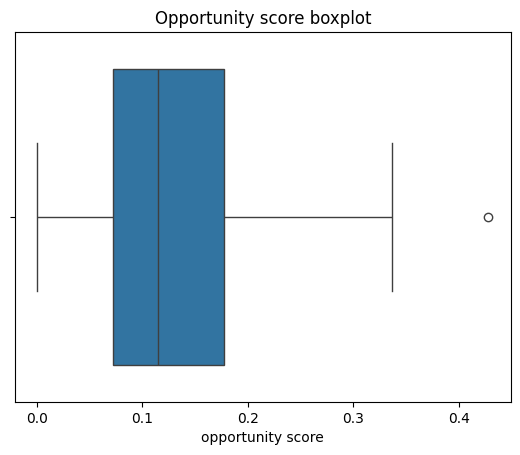

In [28]:
sns.boxplot(data=coffee_shop_opp_score_scaled_df, x='opportunity_score')
plt.title("Opportunity score boxplot")
plt.xlabel('opportunity score')
plt.show()

The boxplot reveals one outlier, which corresponds to Santa Barbara. The distribution of opportunity scores appears roughly symmetrical, suggesting a near-normal distribution. Additionally, the wide interquartile range indicates a large spread in the results, reflecting substantial variability among the cities evaluated.

Let's also take a look at the potential for each city in terms of the % of the population that are in ages 25-39. The people in that age bracket are people who tend to go to coffee shops the most. 

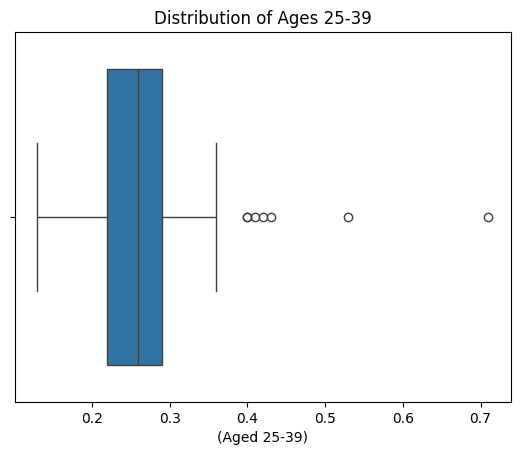

In [29]:
sns.boxplot(data=coffee_shop_opp_score_df, x='(Aged 25-39)')
plt.title("Distribution of Ages 25-39")
plt.show()

There are some outliers in the distribution of ages 25-39 for our list of cities. This may indicate that some cities have very high potential since there is a bigger customer base for a coffee shop.

In [30]:
# export the results to a csv file to plot in power BI

coffee_shop_opp_score_top10_df = coffee_shop_opp_score_df.copy()

coffee_shop_opp_score_top10_df = coffee_shop_opp_score_top10_df[coffee_shop_opp_score_top10_df['city'].isin(coffee_shop_opp_score_scaled_top10_df['city'])]
coffee_shop_opp_score_top10_df = coffee_shop_opp_score_top10_df.merge(coffee_shop_opp_score_scaled_top10_df[['city','opportunity_score']],how='left',on='city')
print(coffee_shop_opp_score_top10_df.head(10).sort_values(by='opportunity_score',ascending=False))

               city state  shops_per_10k_residents  (Aged 25-39)  \
1     Santa Barbara    CA                13.522727         0.168   
4              Reno    NV                 7.636652         0.280   
2       New Orleans    LA                 9.049542         0.241   
7           Clayton    MO                 7.021650         0.260   
9        Isla Vista    CA                 7.705150         0.710   
5  Saint Petersburg    FL                 2.843875         0.240   
6       Saint Louis    MO                 5.039857         0.340   
3      Indianapolis    IN                 3.432349         0.270   
8            Goleta    CA                10.212608         0.330   
0         Nashville    TN                 4.335664         0.229   

   num_coffee_shops  median_checkin_count  median_stars  median_review_counts  \
1               119                 183.0          4.00                  73.0   
4               215                 120.0          4.00                  46.0   
2       

# Grouping Cities Through KMeans

It'd be interesting to see which cities are similar to each other in our top 10 cities for opening up a coffee shop. 

If we open up a coffee shop in one city and it does well, we can select other cities in our last that have similar characteristics. 

For our KMeans model, we will use the following input features:

1. Coffee shop density per 10k residents - this indicates competition
2. % of population 25-39 - this represents demand and potential since most people in this age group like going to coffee shops
3. median household income - this represents viability - can the economics actually work? are customers likely to afford frequent purchases?

Due to time, I could not collect more information like population growth over the last 5 years or average rent. That would add more input features to describe potential and viability. That would be some future next steps. 

Let's generate the dataframe that contains these three features for our top 10 cities.

Note that I have to normalize the input features again based on the top 10 cities rather than the top 100 cities. If my top 10 cities happen to be in the upper end of my normalized range, their normalized values will now cluster close together, making it harder for KMeans to detect variation. I want all features to have equal opportunity to influence clustering within this new dataset.

In [31]:
coffee_shop_kmeans_df = coffee_shop_opp_score_scaled_top10_df.copy()
coffee_shop_kmeans_df = coffee_shop_kmeans_df[['city','state']]

# we just need to include median household income. 
kmeans_data_df = condensed_coffee_shop_list_df[['city','median_household_income','shops_per_10k_residents','(Aged 25-39)']].drop_duplicates(subset='city')

# normalize the values of household income since KMeans model is very sensitive to input features of different magnitudes
coffee_shop_kmeans_df = coffee_shop_kmeans_df.merge(kmeans_data_df, how='left', on='city')

# let's keep a copy of kmeans before normalization so we can compare the cluster results to
coffee_shops_kmeans_noNorm_df = coffee_shop_kmeans_df.copy()

# coffee_shop_kmeans still has median checkin count, num_coffee_shops, and other criteria. let's drop those
coffee_shop_kmeans_df = coffee_shop_kmeans_df[['shops_per_10k_residents','(Aged 25-39)', 'median_household_income']]

# normalize all values 
coffee_shop_kmeans_df['shops_per_10k_residents'] = min_max_norm(coffee_shop_kmeans_df['shops_per_10k_residents'])
coffee_shop_kmeans_df['(Aged 25-39)'] = min_max_norm(coffee_shop_kmeans_df['(Aged 25-39)'])
coffee_shop_kmeans_df['median_household_income'] = min_max_norm(coffee_shop_kmeans_df['median_household_income'])

print(coffee_shop_kmeans_df.head(10))


   shops_per_10k_residents  (Aged 25-39)  median_household_income
0                 1.000000      0.000000                 0.739389
1                 0.448810      0.206642                 0.517086
2                 0.581117      0.134686                 0.298191
3                 0.391219      0.169742                 1.000000
4                 0.455224      1.000000                 0.000000
5                 0.000000      0.132841                 0.466067
6                 0.205638      0.317343                 0.544769
7                 0.055106      0.188192                 0.403953
8                 0.690030      0.298893                 0.896056
9                 0.139696      0.112546                 0.522102


We are ready to setup the Kmeans model. Let's first import the necessary libraries

In [50]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

Let's run 2-9 clusters. 9 is the max since there's only 10 cities available.

In [51]:
inertia_results = []
silhouette_score_results = []

for i in range(2,10):
    kmeans_model = KMeans(n_clusters=i, random_state=42)
    kmeans_model.fit(coffee_shop_kmeans_df)
    inertia_results.append(kmeans_model.inertia_)
    silhouette_score_results.append(silhouette_score(coffee_shop_kmeans_df, kmeans_model.labels_))

print("Inertia Results: ", inertia_results)
print("Silhouette Score Results: ", silhouette_score_results)

Inertia Results:  [1.393879612361005, 1.1875728001192265, 0.39345433603024005, 0.15577444925258122, 0.12047543024158221, 0.062089266441134966, 0.019953984965239063, 0.00497924903014535]
Silhouette Score Results:  [np.float64(0.345806263252652), np.float64(0.2600794844073575), np.float64(0.3395205727872735), np.float64(0.3669002406542248), np.float64(0.22734862841284756), np.float64(0.1719873713048191), np.float64(0.12904755053964118), np.float64(0.07337805891419377)]


Let's plot the inertia and silhouette score results

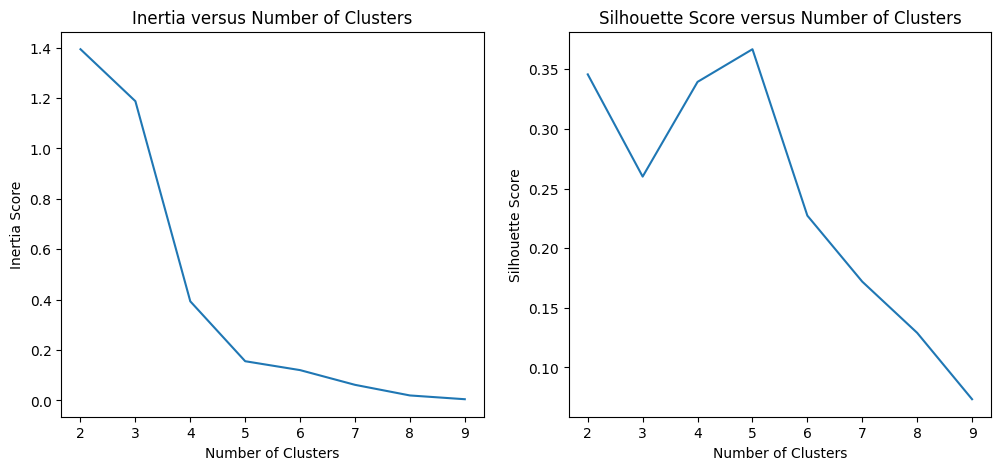

In [52]:
num_of_clusters = [i for i in range(2,10)] # 2-9 clusters 

fig, axes = plt.subplots(1,2,figsize=(12,5))
sns.lineplot(x=num_of_clusters, y=inertia_results, ax=axes[0])
axes[0].set_title("Inertia versus Number of Clusters")
axes[0].set_xlabel('Number of Clusters')
axes[0].set_ylabel('Inertia Score')

sns.lineplot(x=num_of_clusters, y=silhouette_score_results, ax=axes[1])
axes[1].set_title("Silhouette Score versus Number of Clusters")
axes[1].set_xlabel('Number of Clusters')
axes[1].set_ylabel('Silhouette Score')

plt.show()


Using the eblow of the inertia curve, it looks like 5 clusters is the optimal amount of clusters. The silhouette score is not high though, which suggests that the clusters are not spaced very close together. Let's take a look at the 2D PCA plot to get some idea of what the cluster looks like. 

X_pca is: [[ 0.55636769  0.36095822]
 [ 0.03619035  0.02525582]
 [-0.01566216  0.14455744]
 [ 0.36612002 -0.12941758]
 [-0.76231432  0.50210237]
 [-0.1621463  -0.38686245]
 [-0.11680605 -0.13634942]
 [-0.21110152 -0.30183436]
 [ 0.35775179  0.20804888]
 [-0.04839949 -0.28645893]]


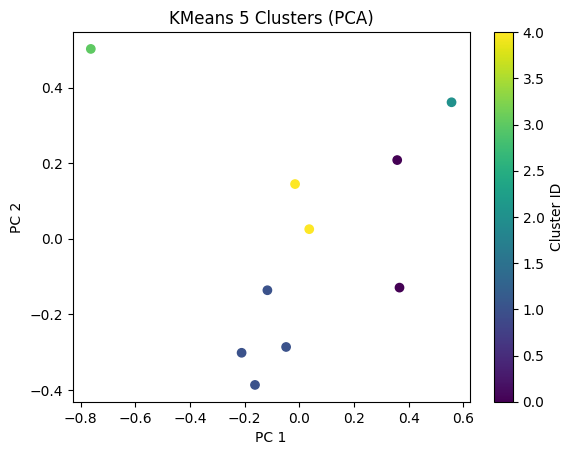

In [53]:
from sklearn.decomposition import PCA 

# set up the PCA object
pca = PCA(n_components=2)
X_pca = pca.fit_transform(coffee_shop_kmeans_df)
print("X_pca is:", X_pca)

# generate a kmeans model with 5 clusters 
kmeans5_model = KMeans(n_clusters=5, random_state=42)
kmeans5_model.fit(coffee_shop_kmeans_df)

# plot the results
plt.scatter(X_pca[:,0], X_pca[:,1], c=kmeans5_model.labels_, cmap= 'viridis')
plt.title("KMeans 5 Clusters (PCA)")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.colorbar(label='Cluster ID')
plt.show()

As we suspected, the points are too spread out. There are some noticeable outliers too. We could rule those outliers out using a DBSCAN model. 

In [54]:
# import the dbscan libraries
from sklearn.cluster import DBSCAN 

# let's make a copy of the kmeans_df for DBSCAN modeling 
coffee_shop_DBSCAN_df = coffee_shop_kmeans_df.copy()

In [56]:
# Run DBSCAN 
dbscan = DBSCAN(eps=0.4, min_samples=2)
dbscan.fit(coffee_shop_DBSCAN_df)

# extract labels
labels = dbscan.labels_
print(labels)

# count clusters and outliers
num_outliers = np.sum(labels == -1)
num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print("number of outliers is: ", num_outliers)
print("number of clusters is: ", num_clusters)

# calculate silhouette score. 
mask = labels != -1

# silhouette score only works if there's at least 2 clusters
if num_clusters >= 2:
    score = silhouette_score(coffee_shop_DBSCAN_df[mask],labels[mask])
else:
    score = 0
    print("not enough clusters\n")
print("silhouette_score is: ", score)

[-1  0  0  1 -1  0  0  0  1  0]
number of outliers is:  2
number of clusters is:  2
silhouette_score is:  0.4616969394131664


Let's plot the results of dbscan clustering 

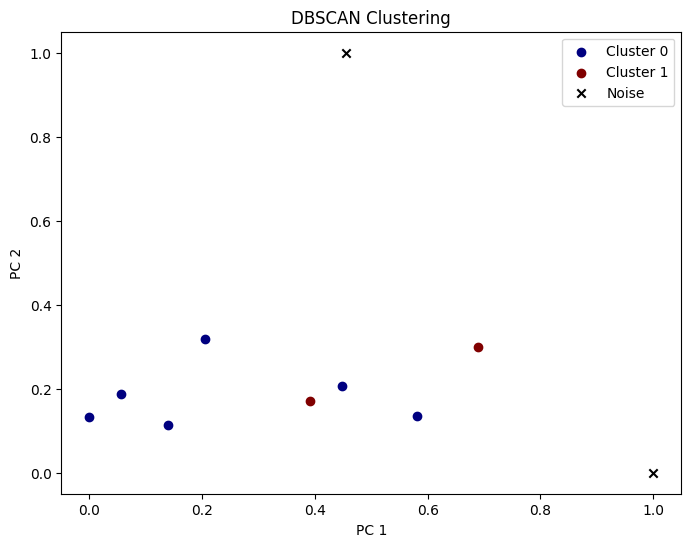

In [57]:
# Plot, code taken from ChatGPT
plt.figure(figsize=(8,6))

for label in set(labels):
    # Points in this cluster
    class_member_mask = (labels == label)
    
    if label == -1:
        # Noise points
        color = 'k'
        marker = 'x'
        label_name = 'Noise'
    else:
        color = plt.cm.jet(float(label) / max(labels))
        marker = 'o'
        label_name = f'Cluster {label}'
    
    xy = coffee_shop_DBSCAN_df[class_member_mask]
    plt.scatter(xy.iloc[:, 0], xy.iloc[:, 1], c=[color], marker=marker, label=label_name)

plt.title("DBSCAN Clustering")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend()
plt.show()

Even though the silhouette score is higher, the grouping is a bit irregular. Let's compare the groupings between kmeans and dbscan for our top 10 list of coffee shops.

In [58]:
coffee_shop_cluster_compare_df = coffee_shops_kmeans_noNorm_df.copy()

coffee_shop_cluster_compare_df['DBSCAN_cluster'] = dbscan.labels_
coffee_shop_cluster_compare_df['KMeans_cluster'] = kmeans5_model.labels_

# print(coffee_shop_cluster_compare_df.head(10))
print(coffee_shop_cluster_compare_df[['city','state','median_household_income','shops_per_10k_residents','(Aged 25-39)','KMeans_cluster']].head(10))


               city state  median_household_income  shops_per_10k_residents  \
0     Santa Barbara    CA                   101672                13.522727   
1              Reno    NV                    78448                 7.636652   
2       New Orleans    LA                    55580                 9.049542   
3           Clayton    MO                   128898                 7.021650   
4        Isla Vista    CA                    24428                 7.705150   
5  Saint Petersburg    FL                    73118                 2.843875   
6       Saint Louis    MO                    81340                 5.039857   
7      Indianapolis    IN                    66629                 3.432349   
8            Goleta    CA                   118039                10.212608   
9         Nashville    TN                    78972                 4.335664   

   (Aged 25-39)  KMeans_cluster  
0         0.168               2  
1         0.280               4  
2         0.241             

Since the data points were not super packed or dense, the DBSCAN had similar results to KMeans. DBSCAN labeled almost all the single grouped clusters as outliers. I think Kmeans has an easier interpretation of the clustering. Any single cluster in KMeans just means that there are no other cities in the top 10 list that is similar to that city.

# Top 10 Factors For A Successful Coffee Shop

The coffee_shop_df contains attributes for every coffee shop. Each attribute is formatted as a Python dictionary. For example, St Honore Pastries's attributes are:

{'RestaurantsDelivery': 'False', 'OutdoorSeating': 'False', 'BusinessAcceptsCreditCards': 'False', 'BusinessParking': "{'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet': False}", 'BikeParking': 'True', 'RestaurantsPriceRange2': '1', 'RestaurantsTakeOut': 'True', 'ByAppointmentOnly': 'False', 'WiFi': "u'free'", 'Alcohol': "u'none'", 'Caters': 'True'}

Some of these attributes, like 'BusinessParking', have nested attributes. If you take all these attributes into account, there's over 50 attributes. 

I personally don't need to know if there's any specific type of parking. I just need to know if there's parking in general. 

So let's consolidate all the attributes down. This will be more reasonable and less demanding on our machine learning models.

Our features will be:
1. hasParking
2. hasWiFi
3. servesAlcohol
4. goodForGroups
5. goodForKids
6. hasOutdoorSeating
7. trendyAmbience
8. casualAmbience
9. petFriendly 
10. priceRange
11. isPriceRangeAvailable
12. total_num_of_amenities
13. isOpenOnWeekends
14. avg_open_hours
15. review_count
16. star_rating
17. population_density
18. median_household_income
19. shops_per_10k_residents

There are 19 features for our models. Our single output feature is total_check_ins for each shop.

Since we are including city features like population density, we will use our data from our condensed city list. Our condensed city list contains cities that have 10 or more coffee shop data available.

Let's first write a function that will evaluate the attribute format.

There are two issues with the cell values in the attribute column. 

The first one is this format - 'WiFi': "u'free'". the u' is an old-style Python 2 syntax that explictly marks a string as unicode string. In python 3+, all strings are unicode strings by default and no longer need the u' pretext. We have to remove the 'u from this string

The second one is nested double quotes like in this example: 'BusinessParking': "{'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet': False}". Nested double quotes is invalid python syntax so we need to convert it to single quotes.

Let's write a function to correct the formatting and then convert the formatted str to a dict

In [349]:
# We need to safely clean up and evaluate the attribute values. Let's write a function to do that
# code provided by chatGPT:

def safe_parse(val):
    try:
        if not isinstance(val, str):
            return {}
        return eval(val, {"__builtins__": None}, {})
    except:
        return {}

'''
explanation:
This function tries to safely convert a messy string into a real Python dictionary. 
eval() is like literal_eval() but more flexible.
We disable all built-in functions with {"__builtins__": None} for safety.
If the string is broken or unparseable, it just returns an empty {}
'''

'\nexplanation:\nThis function tries to safely convert a messy string into a real Python dictionary. \neval() is like literal_eval() but more flexible.\nWe disable all built-in functions with {"__builtins__": None} for safety.\nIf the string is broken or unparseable, it just returns an empty {}\n'

Let's write a second function that will generate some of the new feature columns. 
Some of the features are already made like "is_open" (we'll clean that column header up later)

When going through some of the data, I realized that priceRange and noiseLevel were not available. Let's create separate columns called isPriceRangeAvailable and isNoiseLevelAvailable as possible features that may influence coffee shop success

In [350]:

#code provided by chatGPT

def create_features(attr_str):
    attr_dict = safe_parse(attr_str) #Convert attributes string to dict
    result = {} # To store compressed features

    # 1. hasParking: True if any type of parking available
    # we have to use safe_parse again on BusinessParking since BusinessParking is a stringified dictionary. We need to convert the value to a dict again!
    # the additional or {} is that safe_parse(attr_dict.get('BusinessParking', '{}')) can return None
    # so by doing None or {}, we are guaranteeing that parking will always be a dict
    parking = safe_parse(attr_dict.get('BusinessParking', '{}')) or {}
    result['hasParking'] = int(any(parking.values())) # if there's any true in the array of true false from parking.values(), convert true to 1 or false to 0 

    # 2. hasWiFi: True if WiFi contains 'free'
    result['hasWiFi'] = int(str(attr_dict.get('WiFi', '')).lower().find('free') >= 0)

    # 3. servesAlcohol: True if alcohol is offered (not 'none')
    alcohol = str(attr_dict.get('Alcohol', '')).lower()
    result['servesAlcohol'] = int('none' not in alcohol and alcohol != '')

    # 4. goodForGroups: True if good for groups
    result['goodForGroups'] = int(attr_dict.get('RestaurantsGoodForGroups') == 'True')

    # 5. goodForKids: True if kid-friendly
    result['goodForKids'] = int(attr_dict.get('GoodForKids') == 'True')

    # 6. hasOutdoorSeating: True if outdoor seating available
    result['hasOutdoorSeating'] = int(attr_dict.get('OutdoorSeating') == 'True')

    # 7. trendyAmbience: True if ambience is trendy
    ambience = safe_parse(attr_dict.get('Ambience', '{}')) or {}
    result['trendyAmbience'] = int(ambience.get('trendy') == True)

    # 8. casualAmbience: True if ambience is casual
    result['casualAmbience'] = int(ambience.get('casual') == True)

    # 9. petFriendly: True if dogs are allowed
    result['petFriendly'] = int(attr_dict.get('DogsAllowed') == 'True')

    # 10 and 11. priceRange: Directly extracted from RestaurantsPriceRange2
    raw_price = str(attr_dict.get('RestaurantsPriceRange2', '')).strip()
    if raw_price in ['1', '2', '3', '4']:
        result['priceRange'] = int(raw_price)
        result['isPriceRangeAvailable'] = 1
    else:
        result['priceRange'] = -1 # -1 means price is unknown for right now 
        result['isPriceRangeAvailable'] = 1

    # 12. total amenities count
    result['total_num_of_amenities'] = len(attr_dict)
        
    return pd.Series(result)

Let's make a copy of coffee_shop_df for this specific task of finding the top 10 features for coffee shops. 

In [581]:
coffee_shop_factors_df_us_only_df = condensed_coffee_shop_list_df.copy()
coffee_shop_factors_df_us_only_df = coffee_shop_factors_df_us_only_df[~coffee_shop_factors_df_us_only_df['state'].isin(['AB'])]
coffee_shop_factors_df_us_only_df = coffee_shop_factors_df_us_only_df[~coffee_shop_factors_df_us_only_df['business_id'].str.contains("#NAME", na=False)]
print(coffee_shop_factors_df_us_only_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 5012 entries, 0 to 5450
Data columns (total 23 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   business_id                      5012 non-null   object 
 1   name                             5012 non-null   object 
 2   address                          4994 non-null   object 
 3   city                             5012 non-null   object 
 4   state                            5012 non-null   object 
 5   postal_code                      5011 non-null   object 
 6   latitude                         5012 non-null   float64
 7   longitude                        5012 non-null   float64
 8   city_land_area_sq_mi             5012 non-null   float64
 9   stars                            5012 non-null   float64
 10  review_count                     5012 non-null   int64  
 11  is_open                          5012 non-null   int64  
 12  attributes               

Now let's make one additional feature: isOpenOnWeekends. We'll have to pull in the 'hours' and check if it's open on the weekends. Most people are available to go to coffee shops on weekends. If coffee shops aren't open on weekends, that may reduce a substantial amount of traffic.

In [ ]:
def hours_check(attr_str):
    attr_dict = safe_parse(attr_str) #Convert attributes string to dict
    result = {} # To store compressed features

    # if the hours don't even include saturday or sunday, then shop isn't open on weekends
    if 'Saturday' not in attr_dict or 'Sunday' not in attr_dict:
        result['isOpenOnWeekends'] = 0
    # if Saturday and Sunday are listed but their hours are 0:0-0:0, then they're considered closed
    elif attr_dict.get('Saturday') == '0:0-0:0' or attr_dict.get('Sunday') == '0:0-0:0':
        result['isOpenOnWeekends'] = 0
    # the story is open on weekends
    else:
        result['isOpenOnWeekends'] = 1
    
    # count the avg open hours (total_hours_open / total_days_open)
    ''' 
    the formatted time has different variations:
    7:0 - 20:0 - total time: 13 hours
    0:0 - 0:0 - total time: 0 hours
    6:0 - 15:30 - total time: 9.5 hours

    read each hour str. find the index where ':' happens
    hours = beginning to where : is
    minutes = index of : + 1 to end of str
    convert the str to int
    divide the minutes by 60 since we are calculating everything in hours 
    '''
    total_days_open = len(attr_dict)
    total_hours = 0

    def time_convert(time_str):

        colon_index = time_str.find(':')
        hour = int(time_str[:colon_index])
        minutes = int(time_str[colon_index+1:]) / 60
    
        return hour+minutes 

    for day in attr_dict:

        # get the opening times 
        times = attr_dict[day]

        # split the opening and closing times by the -
        dash_index = times.find('-')
        opening_time = times[:dash_index]
        closing_time = times[dash_index+1:]

        opening_time_hours = time_convert(opening_time)
        closing_time_hours = time_convert(closing_time)

        if closing_time_hours < 12:
            closing_time_hours += 12 # some coffee shops have times '11:0 - 1:0', which is '11:00AM - 1:00PM', which would be '11:00AM - 13:00' need to add 12
        
        total_hours += abs((time_convert(closing_time) - time_convert(opening_time)))           

    if total_days_open == 0:
        result['avg_open_hours'] = 0
    else:
        result['avg_open_hours'] = total_hours/total_days_open
    
    return pd.Series(result)

Use this function on the 'hours' column and assign the output to a new column called 'isOpenOnWeekends' and 'avg_open_hours' per day

In [583]:
coffee_shop_hours_df = coffee_shop_factors_df_us_only_df['hours'].apply(hours_check)
print(coffee_shop_hours_df.info())
print(coffee_shop_hours_df.head(7))

<class 'pandas.core.frame.DataFrame'>
Index: 5012 entries, 0 to 5450
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   isOpenOnWeekends  5012 non-null   float64
 1   avg_open_hours    5012 non-null   float64
dtypes: float64(2)
memory usage: 117.5 KB
None
    isOpenOnWeekends  avg_open_hours
0                1.0       13.428571
3                1.0       10.000000
5                0.0        0.000000
6                1.0        5.142857
7                1.0       12.928571
9                0.0        0.000000
10               1.0        6.285714


Combine the coffee_shop_hours_df with coffee_shop_factors_df

In [584]:
coffee_shop_factors_df_us_only_df = pd.concat([coffee_shop_factors_df_us_only_df, coffee_shop_hours_df], axis=1)
print(coffee_shop_factors_df_us_only_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 5012 entries, 0 to 5450
Data columns (total 25 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   business_id                      5012 non-null   object 
 1   name                             5012 non-null   object 
 2   address                          4994 non-null   object 
 3   city                             5012 non-null   object 
 4   state                            5012 non-null   object 
 5   postal_code                      5011 non-null   object 
 6   latitude                         5012 non-null   float64
 7   longitude                        5012 non-null   float64
 8   city_land_area_sq_mi             5012 non-null   float64
 9   stars                            5012 non-null   float64
 10  review_count                     5012 non-null   int64  
 11  is_open                          5012 non-null   int64  
 12  attributes               

6/23/2025 - I can use the times of checkins as a proxy for how long a coffee shop has been opened for. Since some coffee shops have been open longer than others, the models use data that's biased toward older coffee shops. To make the data more 'fair', we can normalize the amount of checkins by dividing it by years open.

At the time this analysis was done, I hadn't learned dbt. The following code was generated based on my first time learning how to use dbt to create star schemas. I created dimension tables for business info and checkin times. Then I created a fact table for the number of checkins for a given day.

The code below brings in years open from some SQL code

df = pd.read_sql(""" 
WITH table1 AS(
	SELECT 
		b.business_id as business_id,
		ROUND((MAX(checkin_date)-MIN(checkin_date))/365.0,2) as years_open,
		SUM(f.checkin_count) AS total_checkins,
		AVG(f.checkin_count) as avg_checkins
	FROM
		fact_checkin as f
	JOIN
		dim_business as b
	ON
		f.business_id = b.business_id
	GROUP BY
		b.business_id
	ORDER BY
		avg_checkins DESC
)

SELECT DISTINCT
	t1.business_id,
	b2.name,
	t1.total_checkins,
	t1.avg_checkins,
	t1.years_open,
	b2.stars
FROM
	table1 as t1
JOIN
	dim_business as b2
ON
	t1.business_id = b2.business_id
ORDER BY
	avg_checkins DESC
""",engine)

print(df.head(10))

df.to_csv('years_open.csv',index=False)

In [493]:
years_open_df = pd.read_csv('years_open.csv')

Let's bring in the totals checkins, population density, median household income, shops per 10k residents, and % of population ages 25-39 into the list of factors

In [585]:
coffee_shop_factors_df_us_only_df = coffee_shop_factors_df_us_only_df.merge(years_open_df[['business_id','years_open']],how='left',on='business_id') \

coffee_shop_factors_df_us_only_df['shops_per_10k_residents'] = coffee_shop_factors_df_us_only_df['num_coffee_shops'] / (coffee_shop_factors_df_us_only_df['population_estimate']/ 10000)  

# if years_open < 1, then set years_open = 1. 
coffee_shop_factors_df_us_only_df.loc[coffee_shop_factors_df_us_only_df['years_open'] < 1, 'years_open'] = 1

# calculate checkins_per_year
coffee_shop_factors_df_us_only_df['checkins_per_year'] = coffee_shop_factors_df_us_only_df['total_checkins'] / coffee_shop_factors_df_us_only_df['years_open']

print(coffee_shop_factors_df_us_only_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5012 entries, 0 to 5011
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   business_id                      5012 non-null   object 
 1   name                             5012 non-null   object 
 2   address                          4994 non-null   object 
 3   city                             5012 non-null   object 
 4   state                            5012 non-null   object 
 5   postal_code                      5011 non-null   object 
 6   latitude                         5012 non-null   float64
 7   longitude                        5012 non-null   float64
 8   city_land_area_sq_mi             5012 non-null   float64
 9   stars                            5012 non-null   float64
 10  review_count                     5012 non-null   int64  
 11  is_open                          5012 non-null   int64  
 12  attributes          

Now let's use our create_features function to generate the columns for our 12 features. 
Then combine the features into a new table called coffee_shop_combined_df so we have a clean table with just our features and output/target variable

In [586]:
coffee_shop_attributes_df = coffee_shop_factors_df_us_only_df['attributes'].apply(create_features)

print(coffee_shop_attributes_df.info())
print(coffee_shop_attributes_df.head(5))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5012 entries, 0 to 5011
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   hasParking              5012 non-null   int64
 1   hasWiFi                 5012 non-null   int64
 2   servesAlcohol           5012 non-null   int64
 3   goodForGroups           5012 non-null   int64
 4   goodForKids             5012 non-null   int64
 5   hasOutdoorSeating       5012 non-null   int64
 6   trendyAmbience          5012 non-null   int64
 7   casualAmbience          5012 non-null   int64
 8   petFriendly             5012 non-null   int64
 9   priceRange              5012 non-null   int64
 10  isPriceRangeAvailable   5012 non-null   int64
 11  total_num_of_amenities  5012 non-null   int64
dtypes: int64(12)
memory usage: 470.0 KB
None
   hasParking  hasWiFi  servesAlcohol  goodForGroups  goodForKids  \
0           1        1              0              0            

In [587]:
coffee_shop_combined_df = pd.concat([coffee_shop_factors_df_us_only_df[['business_id','name','total_checkins','isOpenOnWeekends','avg_open_hours','population_density','median_household_income','shops_per_10k_residents','review_count','stars','num_coffee_shops','years_open','checkins_per_year']], coffee_shop_attributes_df], axis=1)
print(coffee_shop_combined_df.info())
# filter out cities where there are less than 10 coffee shops worth of data. We're doing this because we are including city features in our model. We need sufficient city coffee shop count data
# coffee_shop_combined_df = coffee_shop_combined_df[coffee_shop_combined_df['num_coffee_shops'] >= 10]
# print(coffee_shop_combined_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5012 entries, 0 to 5011
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   business_id              5012 non-null   object 
 1   name                     5012 non-null   object 
 2   total_checkins           5012 non-null   float64
 3   isOpenOnWeekends         5012 non-null   float64
 4   avg_open_hours           5012 non-null   float64
 5   population_density       5012 non-null   float64
 6   median_household_income  5012 non-null   int64  
 7   shops_per_10k_residents  5012 non-null   float64
 8   review_count             5012 non-null   int64  
 9   stars                    5012 non-null   float64
 10  num_coffee_shops         5012 non-null   int64  
 11  years_open               4966 non-null   float64
 12  checkins_per_year        4966 non-null   float64
 13  hasParking               5012 non-null   int64  
 14  hasWiFi                 

So there are some missing years open and checkins_per_year because the data isn't available. Let's remove those from our analysis. 

In [588]:
coffee_shop_combined_df = coffee_shop_combined_df[coffee_shop_combined_df['years_open'].notna()]
print(coffee_shop_combined_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 4966 entries, 0 to 5011
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   business_id              4966 non-null   object 
 1   name                     4966 non-null   object 
 2   total_checkins           4966 non-null   float64
 3   isOpenOnWeekends         4966 non-null   float64
 4   avg_open_hours           4966 non-null   float64
 5   population_density       4966 non-null   float64
 6   median_household_income  4966 non-null   int64  
 7   shops_per_10k_residents  4966 non-null   float64
 8   review_count             4966 non-null   int64  
 9   stars                    4966 non-null   float64
 10  num_coffee_shops         4966 non-null   int64  
 11  years_open               4966 non-null   float64
 12  checkins_per_year        4966 non-null   float64
 13  hasParking               4966 non-null   int64  
 14  hasWiFi                  4966

In [589]:
print(coffee_shop_combined_df.describe())

       total_checkins  isOpenOnWeekends  avg_open_hours  population_density  \
count     4966.000000       4966.000000     4966.000000         4966.000000   
mean       224.573298          0.687273        8.338979         4946.668424   
std        748.152834          0.463651        5.118767         4117.155011   
min          1.000000          0.000000        0.000000          497.520047   
25%         23.000000          0.000000        5.428571         2285.323920   
50%         69.000000          1.000000        8.666667         3596.491228   
75%        227.000000          1.000000       12.000000         5642.666667   
max      40109.000000          1.000000       20.000000        33175.925930   

       median_household_income  shops_per_10k_residents  review_count  \
count              4966.000000              4966.000000   4966.000000   
mean              80558.003625                 7.180080     75.199758   
std               31944.029520                 5.498407    165.846241

Let's take a look at the distribution of the checkins per year

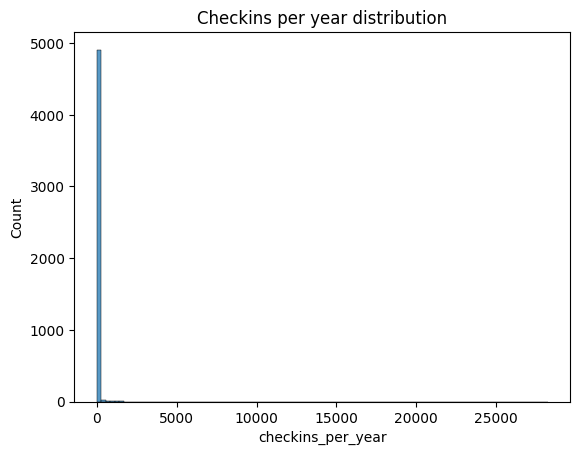

In [590]:
sns.histplot(data=coffee_shop_combined_df,x='checkins_per_year', bins=100)
plt.title("Checkins per year distribution")
plt.show()

So our distribtuion is very right-skewed. We have two coffee shops that have more than 10,000 check ins (one has 40k check ins)! 

 A few very high check in values can dominate the loss functions. 
 The model can put too much effort trying to fit those outliers.
 So let's take the np.log1p(x) == np.log(1+x) -> using np.log1p can handle if x or total check-ins is 0.

 Replot the log1p graph count to see how the distribution changes

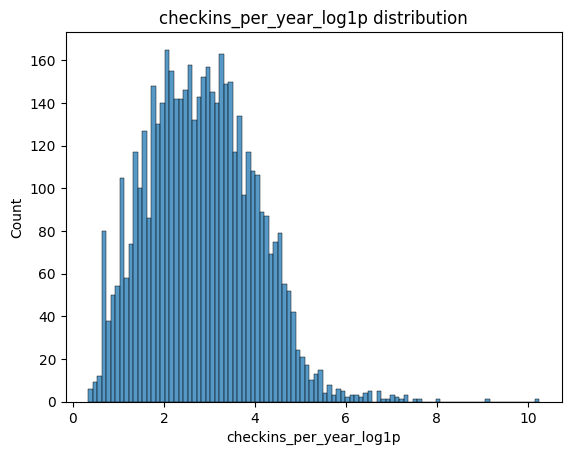

In [591]:
coffee_shop_combined_df['checkins_per_year_log1p'] = np.log1p(coffee_shop_combined_df['checkins_per_year'])

sns.histplot(data=coffee_shop_combined_df,x='checkins_per_year_log1p', bins=100)
plt.title("checkins_per_year_log1p distribution")
plt.show()

Let's see what our coffee_shop_combined_df table of data looks like. We want to make sure it has everything we need to construct our models

Our population estimate has some inf values. Let's set those infinite values to 0.

In [592]:
coffee_shop_combined_df['shops_per_10k_residents'] = coffee_shop_combined_df['shops_per_10k_residents'].replace([np.inf, -np.inf], 0)
print(coffee_shop_combined_df.describe())

       total_checkins  isOpenOnWeekends  avg_open_hours  population_density  \
count     4966.000000       4966.000000     4966.000000         4966.000000   
mean       224.573298          0.687273        8.338979         4946.668424   
std        748.152834          0.463651        5.118767         4117.155011   
min          1.000000          0.000000        0.000000          497.520047   
25%         23.000000          0.000000        5.428571         2285.323920   
50%         69.000000          1.000000        8.666667         3596.491228   
75%        227.000000          1.000000       12.000000         5642.666667   
max      40109.000000          1.000000       20.000000        33175.925930   

       median_household_income  shops_per_10k_residents  review_count  \
count              4966.000000              4966.000000   4966.000000   
mean              80558.003625                 7.180080     75.199758   
std               31944.029520                 5.498407    165.846241

Our data is looking pretty good. Let's build our models now. 

From my Google Analytics Program, I've learned Single Decision Tree, Bagging (Random Forest), and XGBoost models.

I'll run all three and evaluate which model has the best performance. Then I'll evaluate the feature importance on the champion model. 

Let's bring in all the libraries needed to run each model

In [508]:
from sklearn.model_selection import GridSearchCV, train_test_split, PredefinedSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from xgboost import plot_importance
import shap

# to save models so I don't need to rerun
import pickle 

Before building our models, let's prepare our data. I'll split the data into training, validation, and testing.
1. Training: 75% of the data
2. Testing: 25% of the data

Our approach with the data is the following:

1. Split the data into training and test sets
2. Tune hyperparameters using cross-validation on the training set
3. Run each model through the test set.
4. select champion model with highest R2 score

In [509]:
print(coffee_shop_combined_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 4966 entries, 0 to 5011
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   business_id              4966 non-null   object 
 1   name                     4966 non-null   object 
 2   total_checkins           4966 non-null   float64
 3   isOpenOnWeekends         4966 non-null   float64
 4   avg_open_hours           4966 non-null   float64
 5   population_density       4966 non-null   float64
 6   median_household_income  4966 non-null   int64  
 7   shops_per_10k_residents  4966 non-null   float64
 8   review_count             4966 non-null   int64  
 9   stars                    4966 non-null   float64
 10  num_coffee_shops         4966 non-null   int64  
 11  years_open               4966 non-null   float64
 12  checkins_per_year        4966 non-null   float64
 13  hasParking               4966 non-null   int64  
 14  hasWiFi                  4966

In [593]:
# 6/2/2025 - the models overfit to the training data and underfit the test data.
# As we saw above, the total checks is very rightly skewed so let's stratify the the total check-ins by bins 
coffee_shop_combined_df['checkin_per_year_bin'] = pd.qcut(coffee_shop_combined_df['checkins_per_year_log1p'], q=10,duplicates='drop')

X = coffee_shop_combined_df.drop(columns=['name', 'total_checkins','checkin_per_year_bin','checkins_per_year_log1p','checkins_per_year','business_id','years_open'], axis=1)
y = coffee_shop_combined_df['checkins_per_year_log1p']
stratify_bins = coffee_shop_combined_df['checkin_per_year_bin']

# split the data to 85% train and 15% test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, stratify=stratify_bins, random_state=42)


## Build A Single Decision Tree

Make a decision tree instance called decision_tree and pass in 42 to the random state parameter so that anybody else who runs this code will get the same results. Fit the model on the training set and then use the predict() function on the x_test to determine final performance.

In [598]:
decision_tree = DecisionTreeRegressor(random_state=42)

cv_params = {
    'max_depth': [3, 4, 5, 6],
    'min_samples_split': [5, 10, 20],
    'min_samples_leaf': [3,5,7],
    'max_features': [None, 'sqrt', 0.5, 10],
}

scoring = ['neg_root_mean_squared_error','neg_mean_absolute_error','r2']

decision_tree_cv = GridSearchCV(decision_tree, cv_params, scoring=scoring, cv=5, refit='r2')


Run the single decision tree model. Use %%time to measure time

In [599]:
%%time 
decision_tree_cv.fit(X_train,y_train)

CPU times: total: 6.12 s
Wall time: 6.1 s


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42),
             param_grid={'max_depth': [3, 4, 5, 6],
                         'max_features': [None, 'sqrt', 0.5, 10],
                         'min_samples_leaf': [3, 5, 7],
                         'min_samples_split': [5, 10, 20]},
             refit='r2',
             scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error',
                      'r2'])

Let's evaluate the performance by looking at the errors and R2. Let's write a function that will neatly print out the best results. We'll use this when examining the results for Random Forest and XGBoost models as well.

In [596]:
def make_validation_results(model_name, model_object):
    '''
    Accepts as arguments a model name (your choice - string) and
    a fit GridSearchCV model object.
  
    Returns a pandas df with the R2, RMSE, and MAE scores
    for the model with the best mean R2 score across all validation folds.  
    '''

    # Retreive the best model 
    best_model = model_object.best_estimator_

    # run the model against the validation set
    y_predict = best_model.predict(X_test)
    y_predict_actual = np.expm1(y_predict)
    y_test_actual = np.expm1(y_test)
    
    # Extract R2, RMSE, and MAE scores from that row
    R2 = r2_score(y_test_actual, y_predict_actual)
    RMSE = np.sqrt(mean_squared_error(y_test_actual, y_predict_actual))
    MAE = mean_absolute_error(y_test_actual, y_predict_actual)
  
    # Create table of results
    table = pd.DataFrame({'Model': [model_name],
                          'R2': [R2],
                          'RMSE': [RMSE],
                          'MAE': [MAE],
                         }
                        )
  
    return table

In [600]:
decision_tree_results = make_validation_results('Single Decision Tree',decision_tree_cv)
print(decision_tree_results)

                  Model        R2        RMSE       MAE
0  Single Decision Tree -0.158359  103.697682  22.43559


Let's get the best model and its feature importances

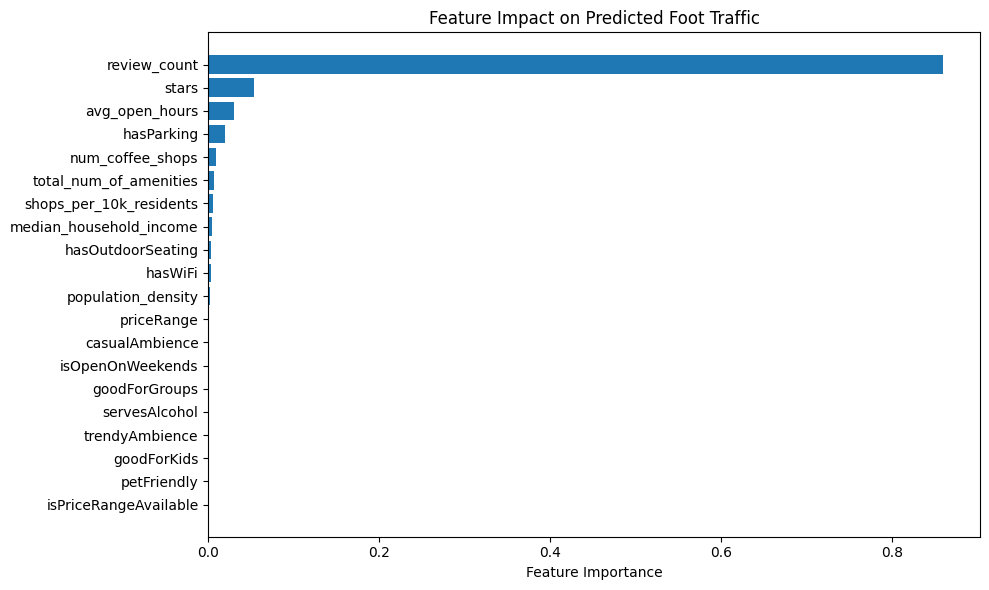

In [601]:
best_decision_tree_model = decision_tree_cv.best_estimator_
importances = best_decision_tree_model.feature_importances_
features = X_train.columns

# Create a DataFrame
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot it
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.gca().invert_yaxis()  # Highest importance on top
plt.xlabel("Feature Importance")
plt.title("Feature Impact on Predicted Foot Traffic")
plt.tight_layout()
plt.show()

## Build A Random Forest Model

In [629]:
rf = RandomForestRegressor(random_state=42)

cv_params = {
    'n_estimators': [50, 100, 150, 200, 250],
    'max_depth': [3, 4, 5, 6, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['sqrt', 0.5, 10],
    'max_samples': [0.8, 1.0]
}

# claude ai recommended:
# cv_params = {
#     'n_estimators': [100, 150, 200],  # RF needs more trees than XGBoost
#     'max_depth': [3, 4, 5, 6],  # Remove 10 (too deep)
#     'min_samples_split': [5, 10, 15],  # Remove 2 (too small)
#     'min_samples_leaf': [3, 5, 7],  # Remove 1 (too small, like XGBoost lesson)
#     'max_features': ['sqrt', 0.5],  # Remove 10 (probably too many)
#     'max_samples': [0.8, 0.9]  # Remove 1.0 (adds some randomness)
# }

scoring = ['neg_root_mean_squared_error','neg_mean_absolute_error','r2']

rf_val_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=5, refit='r2',n_jobs=-1, verbose=2)

In [630]:
%%time
rf_val_cv.fit(X_train,y_train)

Fitting 5 folds for each of 1350 candidates, totalling 6750 fits
CPU times: total: 22.9 s
Wall time: 5min 11s


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6, 10],
                         'max_features': ['sqrt', 0.5, 10],
                         'max_samples': [0.8, 1.0],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 150, 200, 250]},
             refit='r2',
             scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error',
                      'r2'],
             verbose=2)

In [631]:
random_forest_results = make_validation_results('Random Forest CV',rf_val_cv)
print(random_forest_results)

              Model        R2       RMSE       MAE
0  Random Forest CV  0.384544  75.586805  18.38289


In [632]:
# compare the random forest to decision tree

overall_results_so_far = pd.concat([random_forest_results,decision_tree_results],axis=0)
print(overall_results_so_far)

                  Model        R2        RMSE       MAE
0      Random Forest CV  0.384544   75.586805  18.38289
0  Single Decision Tree -0.158359  103.697682  22.43559


So the random forest model did better than the single decision tree. 

In [609]:
path = r'C:\Users\Jerry Mar\Desktop\Google Data Analytics Program\Personal_Projects\Coffee'
with open(path+'rf_cv_model.pickle', 'wb') as to_write:
    pickle.dump(rf_val_cv, to_write)

In [223]:
# Open pickled model - use only when you don't want to rerun the model.
with open(path+'rf_cv_model.pickle', 'rb') as to_read:
    rf_val_cv = pickle.load(to_read) 

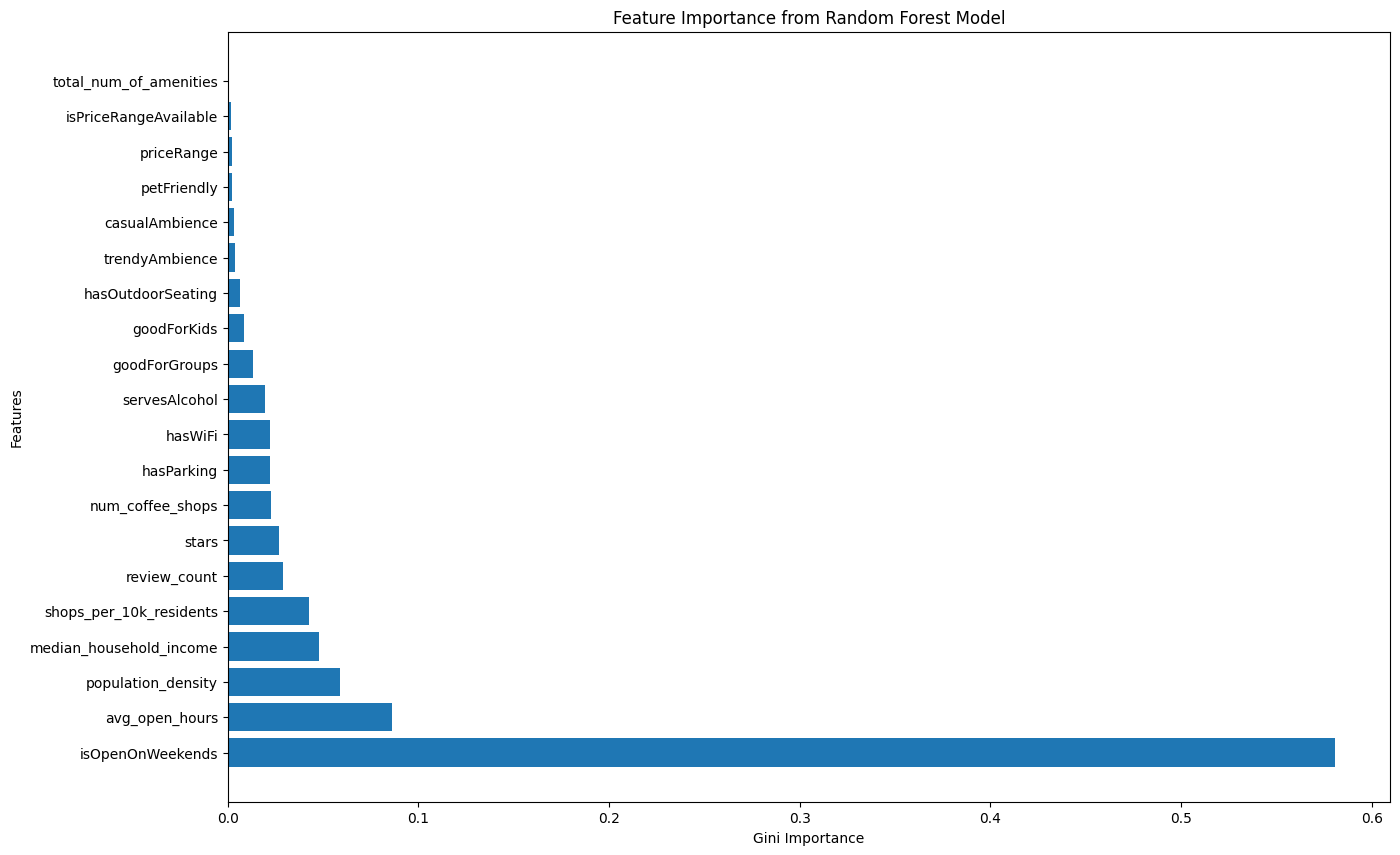

In [633]:
# get feature importances 
best_rf = rf_val_cv.best_estimator_
importances = best_rf.feature_importances_
feature_names = X_train.columns
forest_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(15,10))
plt.barh(feature_names, forest_importances)
plt.title('Feature Importance from Random Forest Model')
plt.xlabel('Gini Importance')
plt.ylabel('Features')
plt.show()

## Build A XGBoost Model

In [626]:
xgb = XGBRegressor(random_state=42)

# cv_params = {
#     'n_estimators': [200, 500, 1000],
#     'min_child_weight': [1,2,3],
#     'max_depth': [3,4,5,6,10],
#     'subsample': [0.25, 0.5, 0.75],
#     'colsample_bytree': [0.25, 0.5, 0.75],
#     'learning_rate': [0.01, 0.05, 0.1, 0.2],
#     'reg_alpha': [0, 1, 5],
#     'reg_lambda': [1, 5, 10]
# }

# chatGPT recommended
# my params were causing overfitting, especially the n_estimators, max_depth, min child weights
cv_params = {
    'n_estimators': [50, 60, 70, 80, 90],  
    'max_depth': [3, 4, 5, 6],  
    'min_child_weight': [3, 5, 7, 10],  
    'subsample': [0.6, 0.8],  
    'colsample_bytree': [0.6, 0.8],  
    'learning_rate': [0.01, 0.05, 0.1],  
    'reg_alpha': [1, 5, 10],  
    'reg_lambda': [5, 10, 20]  
}

scoring = ['neg_root_mean_squared_error','neg_mean_absolute_error','r2']

xgb_val_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=5, refit='r2',n_jobs=-1, verbose=2)

In [627]:
%%time 
xgb_val_cv.fit(X_train,y_train)

Fitting 5 folds for each of 8640 candidates, totalling 43200 fits
CPU times: total: 1min 7s
Wall time: 5min 16s


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None...
                                    n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.8],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 4, 5, 6],
                         'min_child_weight': [3, 5, 7, 10],
                         'n_estimators': [50, 60, 70, 80, 90],
                         'reg_alpha': [1, 5, 10], 'reg_lambda': [5, 10, 20],
                         'subsample': [0.6, 0.8]},
             refit='r2',
             scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error',
                      'r2'],
             verbose=2)

In [295]:
path = r'C:\Users\Jerry Mar\Desktop\Google Data Analytics Program\Personal_Projects\Coffee'
with open(path+'xgb_cv_model.pickle', 'wb') as to_write:
    pickle.dump(xgb_val_cv, to_write)

In [228]:
# Open pickled model
with open(path+'xgb_cv_model.pickle', 'rb') as to_read:
    xgb_val_cv = pickle.load(to_read) 

In [628]:
XGB_results = make_validation_results('XGBoost CV',xgb_val_cv)
print(XGB_results)

        Model        R2       RMSE        MAE
0  XGBoost CV  0.390707  75.207421  18.538683


In [634]:
# let's take a look at the overall results to see which model performed the best

final_results = pd.concat([overall_results_so_far, XGB_results], axis=0)
print(final_results)

                  Model        R2        RMSE        MAE
0      Random Forest CV  0.384544   75.586805  18.382890
0  Single Decision Tree -0.158359  103.697682  22.435590
0            XGBoost CV  0.390707   75.207421  18.538683


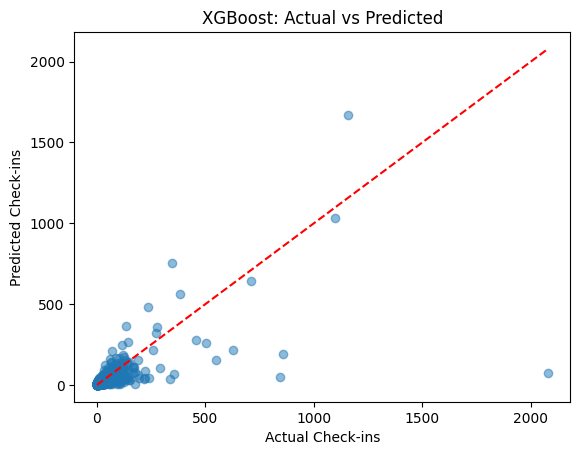

In [635]:
# Let's take a look at the error distribution

best_model = xgb_val_cv.best_estimator_

plt.scatter(np.expm1(y_test), np.expm1(best_model.predict(X_test)), alpha=0.5)
plt.xlabel("Actual Check-ins")
plt.ylabel("Predicted Check-ins")
plt.title("XGBoost: Actual vs Predicted")
plt.plot([np.expm1(y_test).min(), np.expm1(y_test).max()], [np.expm1(y_test).min(), np.expm1(y_test).max()], 'r--')
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

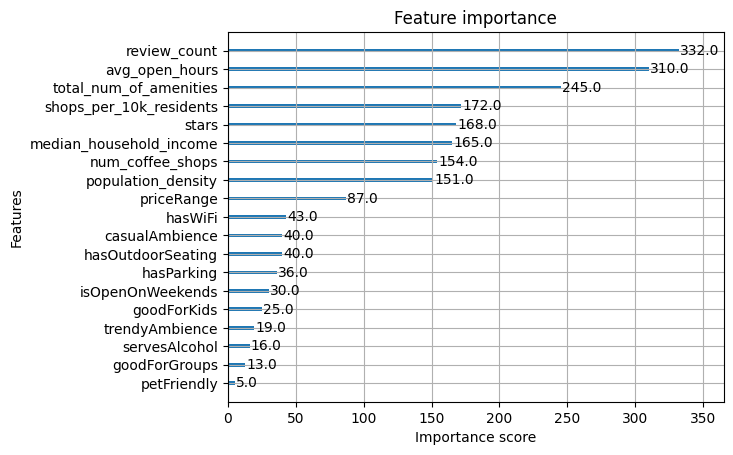

In [636]:
# Plot the relative feature importance of the predictor variables

plot_importance(xgb_val_cv.best_estimator_)

Let's see what the shap values are for each feature. The plot importances tell you how often a feature was used in trees while SHAP values tell you how much a feature influences each prediction. 

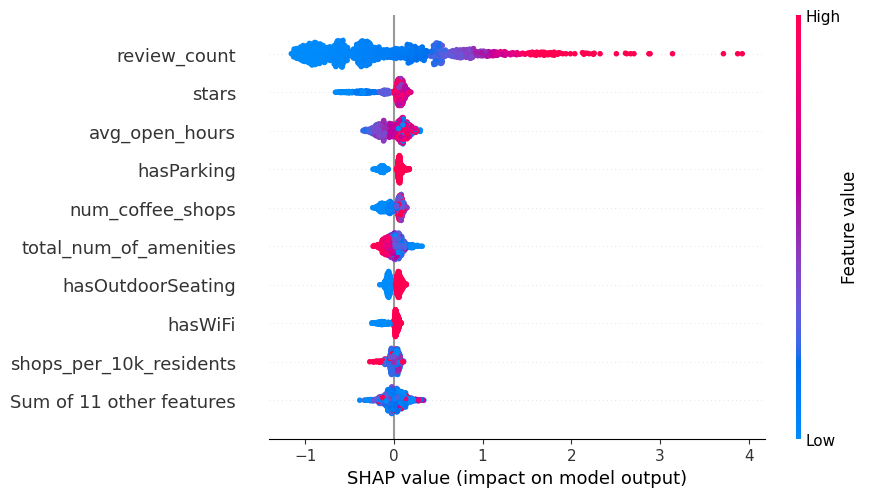

In [637]:
explainer = shap.TreeExplainer(xgb_val_cv.best_estimator_)
shap_values = explainer(X_test)
shap.plots.beeswarm(shap_values)